In [1]:
import os, sys, json, random, math
import numpy as np
import torch
import matplotlib.pyplot as plt

from omegaconf import OmegaConf

# ---- CHANGE THESE TWO PATHS AS NEEDED ----
REPO_ROOT = "/home/yb107/cvpr2025/DukeDiffSeg"
BASE_CONFIG = "/home/yb107/cvpr2025/DukeDiffSeg/configs/diffunet_v4/config.yaml"
CHECKPOINT = "/home/yb107/cvpr2025/DukeDiffSeg/outputs/.../checkpoints/final_unet.pth"  # <--- set your path

# Make repo importable
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# --- Notebook cell 1: Import your code & helpers ---
from model.diffUNet.BTCV import DiffUNet
from utils.data import list_from_jsonl, sdf_to_mask, mask_to_sdf, MaskToSDFd
from utils.data import add_spacing  # used inside get_transforms in your training script

# We'll reuse your get_transforms, but in notebook we want finer control.
# If you prefer your exact training transforms, you can also do:
# from <your_training_script> import get_transforms
from monai import transforms
from monai.data import Dataset, DataLoader, list_data_collate
from monai.inferers import SlidingWindowInferer
from monai.utils import set_determinism
from monai.transforms import Compose

import cc3d
from scipy import ndimage as ndi

In [3]:
# --- Notebook cell 2: Load config & set inference overrides ---
cfg = OmegaConf.load(BASE_CONFIG)

# --- Minimal, safe overrides for quick inference ---
cfg.training.inference_mode = True
cfg.experiment.debug = True  # keeps things lightweight
cfg.training.num_gpus = 1
cfg.data.batch_size_per_gpu = 1
cfg.data.val_batch_size = 1
cfg.data.shuffle_train_data = False
cfg.evaluation.validation_max_num_samples = 2  # we only want 1–2 samples
cfg.amp.enabled = False  # keep simple in notebook; switch to True if you like

# If you want to avoid persistent caching (safer in ad-hoc notebooks):
# cfg.data.cache_dir = None  # uncomment if you don't want caching here

print(OmegaConf.to_yaml(cfg, resolve=True)[:800], "\n...\n")  # peek
set_determinism(seed=int(cfg.seed) if cfg.seed is not None else 0)

ConfigAttributeError: Missing key training
    full_key: training
    object_type=dict

In [4]:
# --- Notebook cell 3: Build inference transforms (val-style) ---
def build_infer_transforms(cfg):
    return Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),
            transforms.Spacingd(
                keys=["image", "label"],
                pixdim=cfg.data.pixdim,
                mode=["nearest", "nearest"],
            ),
            transforms.Orientationd(
                keys=["image", "label"], axcodes=cfg.data.orientation
            ),
            # Optional label pruning logic lives inside your get_transforms;
            # if you need the task-specific pruning, import and use that here.
            transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
            transforms.Resized(
                keys=["image", "label"],
                spatial_size=cfg.data.roi_size,
                mode=["nearest", "nearest"],
            ),
            transforms.Lambda(add_spacing),  # creates "spacing_tensor"
            MaskToSDFd(keys=["image", "label"], spacing_key="spacing_tensor"),
            transforms.ToTensord(
                keys=["image", "label", "spacing_tensor"], device=torch.device("cpu")
            ),
        ]
    )

In [5]:
# --- Notebook cell 4: Build a tiny loader (1–2 cases) ---
val_files = list_from_jsonl(cfg.data.val_jsonl, image_key="mask", label_key="mask")

# pick the first 2 (or random sample if you prefer)
val_files = val_files[: min(2, len(val_files))]
print("Selected cases:", json.dumps(val_files, indent=2)[:700], "\n...\n")

val_ds = Dataset(data=val_files, transform=build_infer_transforms(cfg))
val_loader = DataLoader(
    val_ds,
    batch_size=1,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

ConfigAttributeError: Missing key data
    full_key: data
    object_type=dict

In [ ]:
# --- Notebook cell 5: Init model & load checkpoint ---
net = DiffUNet(
    spatial_dims=cfg.model.params.spatial_dims,
    in_channels=cfg.model.params.in_channels,
    out_channels=cfg.model.params.out_channels,
    features=cfg.model.params.features,
    diffusion_steps=cfg.diffusion.diffusion_steps,
    beta_schedule=cfg.diffusion.beta_schedule,
    ddim_steps=cfg.diffusion.ddim_steps,
    image_size=cfg.data.roi_size,
    use_spacing_info=cfg.model.params.use_spacing_info,
    model_mean_type=cfg.diffusion.model_mean_type,
).to(device)

# Load state dict (strict=True by default; set False if you changed heads)
state = torch.load(CHECKPOINT, map_location="cpu")
missing, unexpected = net.load_state_dict(state, strict=False)
print("Loaded checkpoint.\nMissing keys:", missing, "\nUnexpected:", unexpected)
net.eval()

In [ ]:
# --- Notebook cell 6: Inference function ---
@torch.no_grad()
def run_inference(batch, cfg, net):
    """
    batch: dict with keys 'image', 'label', 'spacing_tensor'
    Returns:
      pred_mask: (1, 1, H, W, D) torch.float32 in {0,1}
      gt_mask:   (1, 1, H, W, D) torch.float32 in {0,1}
      cond_mask: (1, 1, H, W, D) torch.float32 in {0,1}  (from SDF input)
    """
    image = batch["image"].float().to(device)  # SDF condition
    label = batch["label"].float().to(device)  # SDF GT
    spacing = batch["spacing_tensor"].float().to(device)  # (3,) or (B,3)

    inferer = SlidingWindowInferer(
        roi_size=cfg.data.roi_size, sw_batch_size=1, overlap=0.0
    )

    # model_fn follows your evaluator
    model_fn = lambda x: net(
        image=x,
        pred_type="ddim_sample",
        spacing_tensor=spacing,
        guidance_scale=float(cfg.diffusion.guidance_scale),
    )

    pred_sdf = inferer(image, model_fn)  # same shape as image
    pred_mask = sdf_to_mask(pred_sdf).detach().cpu()  # (B,C,H,W,D), binary {0,1}

    gt_mask = sdf_to_mask(label).detach().cpu()
    cond_mask = sdf_to_mask(image).detach().cpu()
    return pred_mask, gt_mask, cond_mask

In [6]:
# --- Notebook cell 7: Post-processing utilities ---


def keep_largest_cc(mask_np, connectivity=26):
    """mask_np: (H,W,D) binary np array -> keeps only largest connected component."""
    lab = cc3d.connected_components(mask_np, connectivity=connectivity)
    counts = np.bincount(lab.ravel())
    if counts.size <= 1:
        return mask_np
    keep_id = counts[1:].argmax() + 1
    return (lab == keep_id).astype(np.uint8)


def remove_small_objects(mask_np, min_size=1000, connectivity=26):
    """Remove components with voxel count < min_size."""
    lab = cc3d.connected_components(mask_np, connectivity=connectivity)
    counts = np.bincount(lab.ravel())
    if counts.size <= 1:
        return mask_np
    keep = np.zeros_like(mask_np, dtype=np.uint8)
    for comp_id, cnt in enumerate(counts[1:], start=1):
        if cnt >= min_size:
            keep |= (lab == comp_id).astype(np.uint8)
    return keep


def fill_holes_3d(mask_np):
    """Binary hole filling per-slice and then 3D; robust combo."""
    # 3D fill
    filled = ndi.binary_fill_holes(mask_np.astype(bool))
    return filled.astype(np.uint8)


def morph_close_3d(mask_np, radius=2):
    """3D binary closing with spherical structuring element."""
    if radius <= 0:
        return mask_np
    # build spherical struct elem
    L = np.arange(-radius, radius + 1)
    Z, Y, X = np.meshgrid(L, L, L, indexing="ij")
    sphere = (X**2 + Y**2 + Z**2) <= radius**2
    closed = ndi.binary_closing(mask_np.astype(bool), structure=sphere)
    return closed.astype(np.uint8)


def dice_binary(a, b, eps=1e-6):
    """a, b: binary np arrays, same shape."""
    inter = (a & b).sum()
    return (2.0 * inter) / (a.sum() + b.sum() + eps)


def run_postproc_suite(pred_mask_t, gt_mask_t, config=None):
    """
    pred_mask_t, gt_mask_t: torch tensors (1,1,H,W,D) in {0,1}
    Returns dict of method -> (dice, processed_mask_np)
    """
    p = pred_mask_t.squeeze().cpu().numpy().astype(np.uint8)
    g = gt_mask_t.squeeze().cpu().numpy().astype(np.uint8)

    results = {}

    # baseline
    d0 = dice_binary(p, g)
    results["baseline"] = (d0, p)

    # LCC
    p_lcc = keep_largest_cc(p)
    results["lcc"] = (dice_binary(p_lcc, g), p_lcc)

    # LCC + Fill holes
    p_lcc_fh = fill_holes_3d(p_lcc)
    results["lcc+fillholes"] = (dice_binary(p_lcc_fh, g), p_lcc_fh)

    # LCC + Remove small (min_size configurable)
    min_size = 500 if config is None else int(config.get("min_size", 500))
    p_rm = remove_small_objects(p_lcc_fh, min_size=min_size)
    results[f"lcc+fillholes+rm{min_size}"] = (dice_binary(p_rm, g), p_rm)

    # LCC + closing
    radius = 2 if config is None else int(config.get("close_radius", 2))
    p_close = morph_close_3d(p_lcc_fh, radius=radius)
    results[f"lcc+fillholes+close{radius}"] = (dice_binary(p_close, g), p_close)

    return results

In [ ]:
# --- Notebook cell 8: Visualization helper ---
def show_triplet(gt_np, pred_np, post_np, title=""):
    """
    gt_np, pred_np, post_np: (H,W,D) binary or float arrays
    """
    H, W, D = gt_np.shape
    z, y, x = D // 2, H // 2, W // 2

    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    fig.suptitle(title, fontsize=14)

    # row 1: GT
    axes[0, 0].imshow(gt_np[:, :, z], cmap="gray")
    axes[0, 0].set_title("GT axial")
    axes[0, 1].imshow(gt_np[:, y, :], cmap="gray")
    axes[0, 1].set_title("GT coronal")
    axes[0, 2].imshow(gt_np[x, :, :], cmap="gray")
    axes[0, 2].set_title("GT sagittal")

    # row 2: pred vs post (overlay pred=red, post=green overlay)
    axes[1, 0].imshow(pred_np[:, :, z], alpha=0.8)
    axes[1, 0].set_title("Pred axial")
    axes[1, 1].imshow(post_np[:, y, :], alpha=0.8)
    axes[1, 1].set_title("Post coronal")
    axes[1, 2].imshow(post_np[x, :, :], alpha=0.8)
    axes[1, 2].set_title("Post sagittal")

    for ax in axes.ravel():
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# import torch

# mean = torch.load(
#     "/home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.2/class_distribution_tensor.pt",
#     weights_only=False,
# )
# print(mean.shape)  # (1,1,128,128,128)

# # squeeze and convert to numpy
# mean_np = mean.squeeze().cpu().numpy()
# print(mean_np.shape, mean_np.dtype, mean_np.min(), mean_np.max())
# # Its is a segmentation mask in LPI orientation with [1,1,1] spacing save it using nibabel to visualize
# import nibabel as nib
# import numpy as np

# nib.save(
#     nib.Nifti1Image(mean_np, np.eye(4)),
#     "/home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.2/class_distribution_tensor.nii.gz",
# )

KeyboardInterrupt: 

In [2]:
import torch

tens = torch.load(
    "/home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.2/colon_pca_cov_eig.pt",
    weights_only=False,
)

Text(0.5, 1.0, 'Eigenvalues of Colon PCA Covariance Matrix')

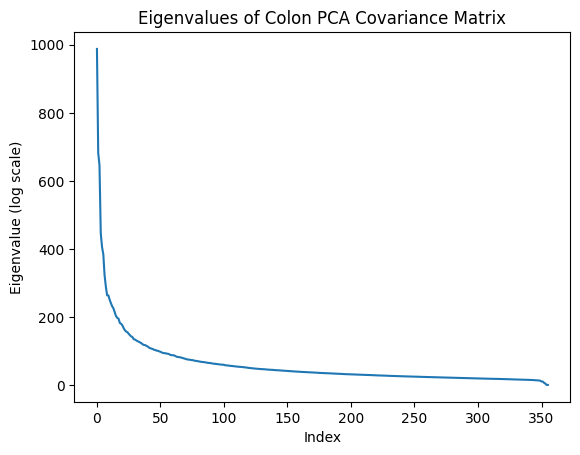

In [3]:
eigenVals = tens["eigenvalues"]
eigenVals.shape

# plot the eigenvalues
import matplotlib.pyplot as plt


plt.plot(eigenVals.cpu().numpy())
# plt.yscale("log")
plt.xlabel("Index")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Eigenvalues of Colon PCA Covariance Matrix")

In [5]:
eigenVals[50], tens.keys()

(tensor(97.4797),
 dict_keys(['mean_flat', 'U', 'eigenvalues', 'volume_shape', 'num_samples', 'note']))

In [8]:
tens["U"].shape, 96**3

(torch.Size([884736, 356]), 884736)

In [19]:
i = 10
eigenVector0 = tens["U"][:, i].reshape(96, 96, 96).cpu().numpy()
# save it using nibabel to visualize
import nibabel as nib
import numpy as np

print(eigenVals[i])
nib.save(
    nib.Nifti1Image(eigenVector0, np.eye(4)),
    f"/home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.2/colon_pca_eigenvector{i}.nii.gz",
)

tensor(250.5415)
